# Importación de librerías

In [2]:
import pandas as pd
import numpy as np
import time 

import os
import librosa
import librosa.display

import matplotlib.pyplot as plt
import seaborn as sns

import mlflow


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import KFold

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Lectura del dataset

In [4]:
urbansound8k_path = "../../data/raw/UrbanSound8K/"

# Primer dataset - Carpeta con los audios
urbansound8k_audio_path = "audio/"

# Segundo dataset - Archivo CSV con metadatos sobre los audios
urbansound8k_metadata_path_file = "metadata/UrbanSound8K.csv" 


mfcc_n_coeficiente = "10"

# Dataset input
dataset_input_path = f"../../data/processed/dataset_mfcc_{mfcc_n_coeficiente}.csv"

# Lectura
dataset_urbansound8k_df = pd.read_csv(dataset_input_path, sep=";")
dataset_urbansound8k_df.head(3)


,fold,classID,mfcc_mean_1,mfcc_mean_2,mfcc_mean_3,mfcc_mean_4,mfcc_mean_5,mfcc_mean_6,mfcc_mean_7,mfcc_mean_8,...,delta2_mfcc_var_1,delta2_mfcc_var_2,delta2_mfcc_var_3,delta2_mfcc_var_4,delta2_mfcc_var_5,delta2_mfcc_var_6,delta2_mfcc_var_7,delta2_mfcc_var_8,delta2_mfcc_var_9,delta2_mfcc_var_10
0,5,3,-275.91843,119.49280,-98.21178,-66.515140,-42.606050,0.505066,-28.330938,-5.746867,...,112.505020,213.598100,39.538475,116.963340,28.015196,153.756260,35.081203,40.550793,19.388300,49.317924
1,5,2,-500.90840,185.10641,-86.53282,49.858850,9.230822,22.548956,-3.567175,12.220052,...,45.168175,41.733723,32.465210,30.765085,34.802017,35.170403,32.595600,35.089226,29.046677,31.543688
2,5,2,-531.19530,186.93994,-70.34916,40.429245,9.121047,18.398588,6.283282,15.504061,...,37.555386,37.222927,33.088345,33.774395,34.858345,33.916622,30.953386,31.146223,27.312347,28.527649


In [18]:
print(f"Cantidad de columnas: {dataset_urbansound8k_df.shape[1]}")
print(f"Cantidad de filas: {dataset_urbansound8k_df.shape[0]}")

print("Columnas del dataset:")
contador = 0
for name in dataset_urbansound8k_df.columns:
    contador +=1
    if contador%5==0:
        print("")        
    print(f"'{name}'", end=", ")

Cantidad de columnas: 167
Cantidad de filas: 8732
Columnas del dataset:
'fold', 'classID', 'mfcc_mean_1', 'mfcc_mean_2', 
'mfcc_mean_3', 'mfcc_mean_4', 'mfcc_mean_5', 'mfcc_mean_6', 'mfcc_mean_7', 
'mfcc_mean_8', 'mfcc_mean_9', 'mfcc_mean_10', 'mfcc_mean_11', 'mfcc_mean_12', 
'mfcc_mean_13', 'mfcc_mean_14', 'mfcc_mean_15', 'mfcc_median_1', 'mfcc_median_2', 
'mfcc_median_3', 'mfcc_median_4', 'mfcc_median_5', 'mfcc_median_6', 'mfcc_median_7', 
'mfcc_median_8', 'mfcc_median_9', 'mfcc_median_10', 'mfcc_median_11', 'mfcc_median_12', 
'mfcc_median_13', 'mfcc_median_14', 'mfcc_median_15', 'mfcc_min_1', 'mfcc_min_2', 
'mfcc_min_3', 'mfcc_min_4', 'mfcc_min_5', 'mfcc_min_6', 'mfcc_min_7', 
'mfcc_min_8', 'mfcc_min_9', 'mfcc_min_10', 'mfcc_min_11', 'mfcc_min_12', 
'mfcc_min_13', 'mfcc_min_14', 'mfcc_min_15', 'mfcc_max_1', 'mfcc_max_2', 
'mfcc_max_3', 'mfcc_max_4', 'mfcc_max_5', 'mfcc_max_6', 'mfcc_max_7', 
'mfcc_max_8', 'mfcc_max_9', 'mfcc_max_10', 'mfcc_max_11', 'mfcc_max_12', 
'mfcc_max_13', 'mf

# Generación datos de entrenamiento y prueba

In [5]:
# Separar las características y la variable objetivo
# ['tasa_cruce_cero', 'entropia_espectograma', 'avg_centroide_espectral'
columnas_caracteristicas_mfcc = [col for col in dataset_urbansound8k_df.columns if 'mfcc' in col]
columna_predecir = 'classID'
columna_fold = 'fold'

# Separar las características y etiquetas
X_caracteristicas = dataset_urbansound8k_df[columnas_caracteristicas_mfcc]  # 'classID' es la etiqueta y 'fold' el número de fold
y = dataset_urbansound8k_df[columna_predecir]
folds = dataset_urbansound8k_df['fold']

# Modelos de Clasificacion

In [6]:
# Iniciar el experimento en MLflow
mlflow.set_experiment(f"RSCV MFCC{mfcc_n_coeficiente} - V2")

<Experiment: artifact_location='file:///c:/Users/colbe/Documents/VIU/TFM/tfm-clasificador-fuentes-sonoras-ciudad/notebooks/modelado/mlruns/838284965544001482', creation_time=1730391618821, experiment_id='838284965544001482', last_update_time=1730391618821, lifecycle_stage='active', name='RSCV MFCC10 - V2', tags={}>

## KNeighborsClassifier

Mejores Parámetros: {'weights': 'uniform', 'n_neighbors': 5, 'metric': 'manhattan'}
Mejor Score: 0.5920474546603783
Fold 1 Accuracy: 0.5258
Tiempo de entrenamiento (segundos): 18.6779


c:\Users\colbe\Documents\VIU\TFM\tfm-clasificador-fuentes-sonoras-ciudad\.env\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Mejores Parámetros: {'weights': 'uniform', 'n_neighbors': 10, 'metric': 'manhattan'}
Mejor Score: 0.5921724294813467
Fold 2 Accuracy: 0.5732
Tiempo de entrenamiento (segundos): 18.0572


c:\Users\colbe\Documents\VIU\TFM\tfm-clasificador-fuentes-sonoras-ciudad\.env\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Mejores Parámetros: {'weights': 'uniform', 'n_neighbors': 10, 'metric': 'manhattan'}
Mejor Score: 0.6027855477855477
Fold 3 Accuracy: 0.5222
Tiempo de entrenamiento (segundos): 17.7974


c:\Users\colbe\Documents\VIU\TFM\tfm-clasificador-fuentes-sonoras-ciudad\.env\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Mejores Parámetros: {'weights': 'uniform', 'n_neighbors': 10, 'metric': 'manhattan'}
Mejor Score: 0.5886138201216972
Fold 4 Accuracy: 0.6192
Tiempo de entrenamiento (segundos): 17.5805


c:\Users\colbe\Documents\VIU\TFM\tfm-clasificador-fuentes-sonoras-ciudad\.env\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Mejores Parámetros: {'weights': 'uniform', 'n_neighbors': 5, 'metric': 'manhattan'}
Mejor Score: 0.5761828116256871
Fold 5 Accuracy: 0.6528
Tiempo de entrenamiento (segundos): 18.1672


c:\Users\colbe\Documents\VIU\TFM\tfm-clasificador-fuentes-sonoras-ciudad\.env\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Mejores Parámetros: {'weights': 'uniform', 'n_neighbors': 10, 'metric': 'manhattan'}
Mejor Score: 0.585143465249884
Fold 6 Accuracy: 0.5930
Tiempo de entrenamiento (segundos): 18.9622


c:\Users\colbe\Documents\VIU\TFM\tfm-clasificador-fuentes-sonoras-ciudad\.env\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Mejores Parámetros: {'weights': 'uniform', 'n_neighbors': 10, 'metric': 'manhattan'}
Mejor Score: 0.595266721214163
Fold 7 Accuracy: 0.5406
Tiempo de entrenamiento (segundos): 18.4955


c:\Users\colbe\Documents\VIU\TFM\tfm-clasificador-fuentes-sonoras-ciudad\.env\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Mejores Parámetros: {'weights': 'uniform', 'n_neighbors': 10, 'metric': 'manhattan'}
Mejor Score: 0.5944915739997707
Fold 8 Accuracy: 0.5248
Tiempo de entrenamiento (segundos): 18.8645


c:\Users\colbe\Documents\VIU\TFM\tfm-clasificador-fuentes-sonoras-ciudad\.env\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Mejores Parámetros: {'weights': 'uniform', 'n_neighbors': 5, 'metric': 'manhattan'}
Mejor Score: 0.5736377683280339
Fold 9 Accuracy: 0.6446
Tiempo de entrenamiento (segundos): 18.1945


c:\Users\colbe\Documents\VIU\TFM\tfm-clasificador-fuentes-sonoras-ciudad\.env\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Mejores Parámetros: {'weights': 'uniform', 'n_neighbors': 10, 'metric': 'manhattan'}
Mejor Score: 0.5815002165856475
Fold 10 Accuracy: 0.5986
Tiempo de entrenamiento (segundos): 18.3624


c:\Users\colbe\Documents\VIU\TFM\tfm-clasificador-fuentes-sonoras-ciudad\.env\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(



Accuracy promedio: 0.5795
Desviación estándar: 0.0474
Tiempo de entrenamiento promedio (segundos): 18.3159


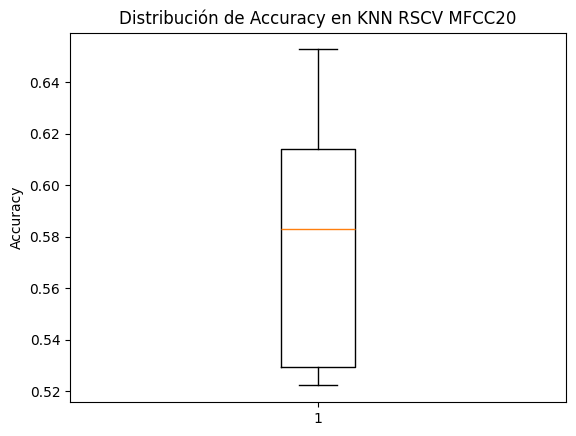

In [28]:
# Definir el modelo KNN
knn = KNeighborsClassifier()

# Definir la rejilla de parámetros para RandomizedSearchCV
param_distributions = {
    'n_neighbors': np.arange(1, 31),  # Número de vecinos a considerar
    'weights': ['uniform', 'distance'],  # Función de peso a usar
    'metric': ['euclidean', 'manhattan', 'minkowski']  # Métrica de distancia
}

# Inicializar lista para almacenar accuracies y tiempos
fold_accuracies = []
fold_training_times = []

# Realizar la validación cruzada respetando los folds predefinidos
for fold in range(1, 11):  # Hay 10 folds en UrbanSound8K

    # Dividir el dataset en entrenamiento y prueba
    train_index = folds != fold
    test_index = folds == fold
    
    X_train, X_test = X_caracteristicas[train_index], X_caracteristicas[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Configurar RandomizedSearchCV
    random_search = RandomizedSearchCV(
        estimator=knn, 
        param_distributions=param_distributions, 
        n_iter=10,  # Número de combinaciones aleatorias a probar
        cv=10,  # Validación cruzada interna con 10 pliegues
        scoring='accuracy',  # Métrica para optimizar
        n_jobs=-1,  # Usar todos los núcleos disponibles
        random_state=42
    )

    # Medir el tiempo de entrenamiento
    start_time = time.time()  # Inicio del tiempo

    # Entrenar el modelo con la búsqueda de hiperparámetros
    random_search.fit(X_train, y_train)

    # Tiempo de finalización
    end_time = time.time()

    # Calcular el tiempo de entrenamiento
    training_time = end_time - start_time
    fold_training_times.append(training_time)

    # Obtener el mejor modelo
    best_knn = random_search.best_estimator_

    # Obtener los mejores parámetros y el mejor score
    best_params = random_search.best_params_
    best_score = random_search.best_score_    
    
    # Predecir y evaluar
    y_pred = best_knn.predict(X_test)
    accuracy_val = accuracy_score(y_test, y_pred)
    f1_val = f1_score(y_test, y_pred, average='weighted' )
    precision_val = precision_score(y_test, y_pred, average='weighted')
    recall_val = recall_score(y_test, y_pred, average='weighted')   

    fold_accuracies.append(accuracy_val)
    
    print(f"Mejores Parámetros: {best_params}")
    print(f"Mejor Score: {best_score}")        
    print(f"Fold {fold} Accuracy: {accuracy_val:.4f}")
    print(f"Tiempo de entrenamiento (segundos): {training_time:.4f}")

    with mlflow.start_run(run_name=f"KNN RSCV MFCC{mfcc_n_coeficiente} Fold_{fold}") as run:
        # Registrar los parámetros y métricas en MLflow
        mlflow.log_params(best_params)

        param_auxilares = {
            "mfcc_coeficiente": mfcc_n_coeficiente, 
            "fold": fold,
            "cv": "RSCV", 
            "model": "KNN"
        }

        mlflow.log_params(param_auxilares)        
        mlflow.set_tags(param_auxilares) 

        # Registrar la métrica de este fold
        mlflow.log_metric(f"accuracy_score", accuracy_val)
        mlflow.log_metric(f"f1_weighted_score", f1_val)
        mlflow.log_metric(f"precision_weighted_score", precision_val)
        mlflow.log_metric(f"recall_weighted_score", recall_val)

        # Registrar el tiempo de entrenamiento
        mlflow.log_metric(f"training_time_seconds", training_time)

        # Guardar el modelo en MLflow con un ejemplo de entrada
        input_example = X_test[:1]  # Ejemplo de entrada, una sola muestra de prueba
        mlflow.sklearn.log_model(best_knn, f"knn_rscv_mfcc{mfcc_n_coeficiente}_fold_{fold}", input_example=input_example)

        # Se finaliza el registro
        mlflow.end_run()


# Mostrar el promedio y desviación estándar
mean_accuracy = np.mean(fold_accuracies)
std_accuracy = np.std(fold_accuracies)
mean_training_time = np.mean(fold_training_times)

print(f"\nAccuracy promedio: {mean_accuracy:.4f}")
print(f"Desviación estándar: {std_accuracy:.4f}")
print(f"Tiempo de entrenamiento promedio (segundos): {mean_training_time:.4f}")

# Opcional: Visualizar los resultados con un boxplot
plt.boxplot(fold_accuracies)
plt.title(f'Distribución de Accuracy en KNN RSCV MFCC{mfcc_n_coeficiente}')
plt.ylabel('Accuracy')
plt.show()


## Random Forest

Mejores Parámetros: {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 50, 'bootstrap': False}
Mejor Score: 0.7211871768690945
Fold 1 Accuracy: 0.7068
Tiempo de entrenamiento (segundos): 475.3988


c:\Users\colbe\Documents\VIU\TFM\tfm-clasificador-fuentes-sonoras-ciudad\.env\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Mejores Parámetros: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 20, 'bootstrap': False}
Mejor Score: 0.7281944624983752
Fold 2 Accuracy: 0.7230
Tiempo de entrenamiento (segundos): 480.4367


c:\Users\colbe\Documents\VIU\TFM\tfm-clasificador-fuentes-sonoras-ciudad\.env\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Mejores Parámetros: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 20, 'bootstrap': False}
Mejor Score: 0.7250999704520831
Fold 3 Accuracy: 0.5719
Tiempo de entrenamiento (segundos): 480.2957


c:\Users\colbe\Documents\VIU\TFM\tfm-clasificador-fuentes-sonoras-ciudad\.env\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Mejores Parámetros: {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 50, 'bootstrap': False}
Mejor Score: 0.7161030257564391
Fold 4 Accuracy: 0.6990
Tiempo de entrenamiento (segundos): 477.4345


c:\Users\colbe\Documents\VIU\TFM\tfm-clasificador-fuentes-sonoras-ciudad\.env\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Mejores Parámetros: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 20, 'bootstrap': False}
Mejor Score: 0.6940507224910306
Fold 5 Accuracy: 0.7607
Tiempo de entrenamiento (segundos): 482.7258


c:\Users\colbe\Documents\VIU\TFM\tfm-clasificador-fuentes-sonoras-ciudad\.env\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Mejores Parámetros: {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 50, 'bootstrap': False}
Mejor Score: 0.7149890380707006
Fold 6 Accuracy: 0.6914
Tiempo de entrenamiento (segundos): 484.3506


c:\Users\colbe\Documents\VIU\TFM\tfm-clasificador-fuentes-sonoras-ciudad\.env\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Mejores Parámetros: {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 50, 'bootstrap': False}
Mejor Score: 0.7138301968522887
Fold 7 Accuracy: 0.6838
Tiempo de entrenamiento (segundos): 488.9018


c:\Users\colbe\Documents\VIU\TFM\tfm-clasificador-fuentes-sonoras-ciudad\.env\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Mejores Parámetros: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 20, 'bootstrap': False}
Mejor Score: 0.710433623753296
Fold 8 Accuracy: 0.7246
Tiempo de entrenamiento (segundos): 491.9391


c:\Users\colbe\Documents\VIU\TFM\tfm-clasificador-fuentes-sonoras-ciudad\.env\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Mejores Parámetros: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 20, 'bootstrap': False}
Mejor Score: 0.7122023011403542
Fold 9 Accuracy: 0.7169
Tiempo de entrenamiento (segundos): 495.6095


c:\Users\colbe\Documents\VIU\TFM\tfm-clasificador-fuentes-sonoras-ciudad\.env\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Mejores Parámetros: {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 50, 'bootstrap': False}
Mejor Score: 0.7208223837255939
Fold 10 Accuracy: 0.7646
Tiempo de entrenamiento (segundos): 485.5432


c:\Users\colbe\Documents\VIU\TFM\tfm-clasificador-fuentes-sonoras-ciudad\.env\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(



Accuracy promedio: 0.7043
Desviación estándar: 0.0509
Tiempo de entrenamiento promedio (segundos): 484.2636


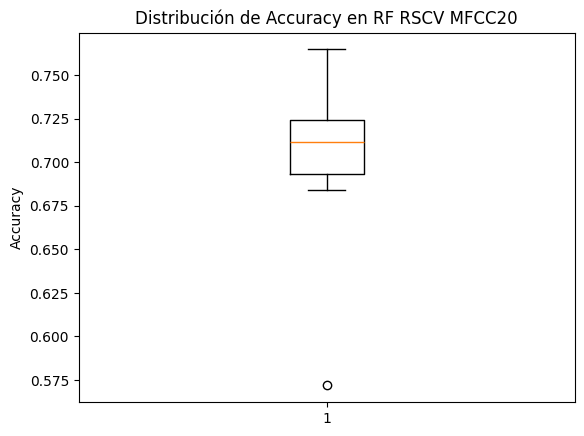

In [29]:
# Definir el modelo Random Forest
rf = RandomForestClassifier(random_state=42)

# Definir la rejilla de parámetros para RandomizedSearchCV
param_distributions = {
    'n_estimators': [10, 50, 100, 200, 500],  # Número de árboles en el bosque
    'max_depth': [None, 10, 20, 30, 40, 50],  # Máxima profundidad de cada árbol
    'min_samples_split': [2, 5, 10],  # Mínimo número de muestras requeridas para dividir un nodo
    'min_samples_leaf': [1, 2, 4],  # Mínimo número de muestras requeridas en una hoja
    'max_features': ['sqrt', 'log2'],  # Número de características a considerar al buscar la mejor división
    'bootstrap': [True, False]  # Método para seleccionar muestras para construir cada árbol
}

# Inicializar lista para almacenar accuracies y tiempos
fold_accuracies = []
fold_training_times = []  # Lista para almacenar los tiempos de entrenamiento

# Realizar la validación cruzada respetando los folds predefinidos
for fold in range(1, 11):  # Hay 10 folds en UrbanSound8K
    # Dividir el dataset en entrenamiento y prueba
    train_index = folds != fold
    test_index = folds == fold
    
    X_train, X_test = X_caracteristicas[train_index], X_caracteristicas[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Configurar RandomizedSearchCV
    random_search = RandomizedSearchCV(
        estimator=rf, 
        param_distributions=param_distributions, 
        n_iter=10,  # Número de combinaciones aleatorias a probar
        cv=10,  # Validación cruzada interna con 10 pliegues
        scoring='accuracy',  # Métrica para optimizar
        n_jobs=-1,  # Usar todos los núcleos disponibles
        random_state=42
    )

    # Medir el tiempo de entrenamiento
    start_time = time.time()  # Inicio del tiempo

    # Entrenar el modelo con la búsqueda de hiperparámetros
    random_search.fit(X_train, y_train)

    # Tiempo de finalización
    end_time = time.time()

    # Calcular el tiempo de entrenamiento
    training_time = end_time - start_time
    fold_training_times.append(training_time)

    # Obtener el mejor modelo
    best_rf = random_search.best_estimator_

    # Obtener los mejores parámetros y el mejor score
    best_params = random_search.best_params_
    best_score = random_search.best_score_
    
    # Predecir y evaluar
    y_pred = best_rf.predict(X_test)
    accuracy_val = accuracy_score(y_test, y_pred)
    f1_val = f1_score(y_test, y_pred, average='weighted' )
    precision_val = precision_score(y_test, y_pred, average='weighted')
    recall_val = recall_score(y_test, y_pred, average='weighted')   
    
    fold_accuracies.append(accuracy_val)

    print(f"Mejores Parámetros: {best_params}")
    print(f"Mejor Score: {best_score}")
    print(f"Fold {fold} Accuracy: {accuracy_val:.4f}")
    print(f"Tiempo de entrenamiento (segundos): {training_time:.4f}")

    with mlflow.start_run(run_name=f"RF RSCV MFCC{mfcc_n_coeficiente} Fold_{fold}") as run:
        # Registrar los parámetros y métricas en MLflow
        mlflow.log_params(best_params)

        param_auxilares = {
            "mfcc_coeficiente": mfcc_n_coeficiente, 
            "fold": fold,
            "cv": "RSCV", 
            "model": "RF"
        }

        mlflow.log_params(param_auxilares)        
        mlflow.set_tags(param_auxilares) 

        # Registrar la métrica de este fold
        mlflow.log_metric(f"accuracy_score", accuracy_val)
        mlflow.log_metric(f"f1_weighted_score", f1_val)
        mlflow.log_metric(f"precision_weighted_score", precision_val)
        mlflow.log_metric(f"recall_weighted_score", recall_val)

        # Registrar el tiempo de entrenamiento
        mlflow.log_metric(f"training_time_seconds", training_time)

        # Guardar el modelo en MLflow con un ejemplo de entrada
        input_example = X_test[:1]  # Ejemplo de entrada, una sola muestra de prueba
        mlflow.sklearn.log_model(best_rf, f"rf_rscv_mfcc{mfcc_n_coeficiente}_fold_{fold}", input_example=input_example)

        # Se finaliza el registro
        mlflow.end_run()


# Mostrar el promedio y desviación estándar
mean_accuracy = np.mean(fold_accuracies)
std_accuracy = np.std(fold_accuracies)
mean_training_time = np.mean(fold_training_times)

print(f"\nAccuracy promedio: {mean_accuracy:.4f}")
print(f"Desviación estándar: {std_accuracy:.4f}")
print(f"Tiempo de entrenamiento promedio (segundos): {mean_training_time:.4f}")

# Opcional: Visualizar los resultados con un boxplot
plt.boxplot(fold_accuracies)
plt.title(f'Distribución de Accuracy en RF RSCV MFCC{mfcc_n_coeficiente}')
plt.ylabel('Accuracy')
plt.show()

## SVM

iniciando
Mejores Parámetros: {'C': 0.001, 'coef0': 0.8771054180315003, 'degree': 3, 'gamma': 1.0, 'kernel': 'linear'}
Mejor Score: 0.6551579390933695
Fold 1 Accuracy: 0.6220
Tiempo de entrenamiento (segundos): 441.0890


c:\Users\colbe\Documents\VIU\TFM\tfm-clasificador-fuentes-sonoras-ciudad\.env\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


iniciando
Mejores Parámetros: {'C': 0.001, 'coef0': 0.8771054180315003, 'degree': 3, 'gamma': 1.0, 'kernel': 'linear'}
Mejor Score: 0.6706850383465488
Fold 2 Accuracy: 0.5788
Tiempo de entrenamiento (segundos): 418.0185


c:\Users\colbe\Documents\VIU\TFM\tfm-clasificador-fuentes-sonoras-ciudad\.env\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


iniciando
Mejores Parámetros: {'C': 0.001, 'coef0': 0.8771054180315003, 'degree': 3, 'gamma': 1.0, 'kernel': 'linear'}
Mejor Score: 0.6669301355921073
Fold 3 Accuracy: 0.5351
Tiempo de entrenamiento (segundos): 433.3378


c:\Users\colbe\Documents\VIU\TFM\tfm-clasificador-fuentes-sonoras-ciudad\.env\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


iniciando
Mejores Parámetros: {'C': 0.001, 'coef0': 0.8771054180315003, 'degree': 3, 'gamma': 1.0, 'kernel': 'linear'}
Mejor Score: 0.6543344169375678
Fold 4 Accuracy: 0.6556
Tiempo de entrenamiento (segundos): 395.2883


c:\Users\colbe\Documents\VIU\TFM\tfm-clasificador-fuentes-sonoras-ciudad\.env\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


iniciando
Mejores Parámetros: {'C': 0.001, 'coef0': 0.8771054180315003, 'degree': 3, 'gamma': 1.0, 'kernel': 'linear'}
Mejor Score: 0.6377355913235246
Fold 5 Accuracy: 0.6571
Tiempo de entrenamiento (segundos): 453.5461


c:\Users\colbe\Documents\VIU\TFM\tfm-clasificador-fuentes-sonoras-ciudad\.env\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


iniciando
Mejores Parámetros: {'C': 0.001, 'coef0': 0.8771054180315003, 'degree': 3, 'gamma': 1.0, 'kernel': 'linear'}
Mejor Score: 0.651776152602858
Fold 6 Accuracy: 0.6525
Tiempo de entrenamiento (segundos): 461.5174


c:\Users\colbe\Documents\VIU\TFM\tfm-clasificador-fuentes-sonoras-ciudad\.env\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


iniciando
Mejores Parámetros: {'C': 0.001, 'coef0': 0.8771054180315003, 'degree': 3, 'gamma': 1.0, 'kernel': 'linear'}
Mejor Score: 0.6490726925606841
Fold 7 Accuracy: 0.7053
Tiempo de entrenamiento (segundos): 419.2353


c:\Users\colbe\Documents\VIU\TFM\tfm-clasificador-fuentes-sonoras-ciudad\.env\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


iniciando
Mejores Parámetros: {'C': 0.001, 'coef0': 0.8771054180315003, 'degree': 3, 'gamma': 1.0, 'kernel': 'linear'}
Mejor Score: 0.6494853962067076
Fold 8 Accuracy: 0.7047
Tiempo de entrenamiento (segundos): 445.5483


c:\Users\colbe\Documents\VIU\TFM\tfm-clasificador-fuentes-sonoras-ciudad\.env\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


iniciando
Mejores Parámetros: {'C': 0.001, 'coef0': 0.8771054180315003, 'degree': 3, 'gamma': 1.0, 'kernel': 'linear'}
Mejor Score: 0.6561153571109324
Fold 9 Accuracy: 0.6630
Tiempo de entrenamiento (segundos): 404.9115


c:\Users\colbe\Documents\VIU\TFM\tfm-clasificador-fuentes-sonoras-ciudad\.env\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


iniciando
Mejores Parámetros: {'C': 0.001, 'coef0': 0.8771054180315003, 'degree': 3, 'gamma': 1.0, 'kernel': 'linear'}
Mejor Score: 0.6519014615520367
Fold 10 Accuracy: 0.6344
Tiempo de entrenamiento (segundos): 450.9172


c:\Users\colbe\Documents\VIU\TFM\tfm-clasificador-fuentes-sonoras-ciudad\.env\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(



Accuracy promedio: 0.6408
Desviación estándar: 0.0497
Tiempo de entrenamiento promedio (segundos): 432.3409


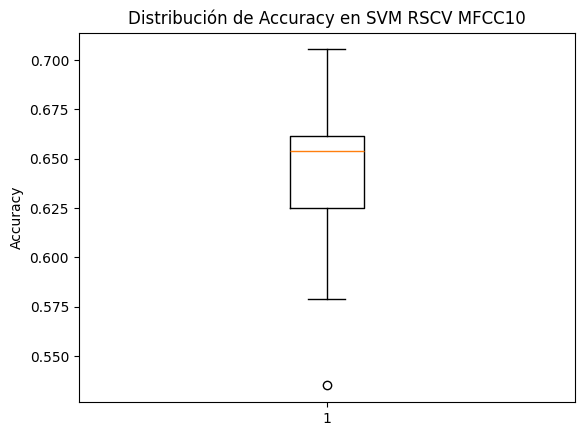

In [7]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from scipy.stats import expon, reciprocal, randint, uniform
import numpy as np

# Definir el modelo SVM
svm = SVC()

# Definir la rejilla de parámetros para RandomizedSearchCV
param_distributions = {
    'C': [0.0001, 0.001],  
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': randint(2, 5),  # Grados 2, 3, 4 para el kernel 'poly'
    'gamma': ['scale', 'auto'] + list(np.logspace(-9, 3, 13)),  # Valores desde 1e-9 hasta 1e3
    'coef0': uniform(-1, 2),  # Valores entre -1 y 1 para 'poly' y 'sigmoid'
}

# Inicializar lista para almacenar accuracies y tiempos
fold_accuracies = []
fold_training_times = []  # Lista para almacenar los tiempos de entrenamiento

# Realizar la validación cruzada respetando los folds predefinidos
for fold in range(1, 11):  # Hay 10 folds en UrbanSound8K
    # Dividir el dataset en entrenamiento y prueba
    train_index = folds != fold
    test_index = folds == fold
    
    X_train, X_test = X_caracteristicas[train_index], X_caracteristicas[test_index]
    y_train, y_test = y[train_index], y[test_index]

    print("iniciando")

    # Configurar RandomizedSearchCV
    random_search = RandomizedSearchCV(
        estimator=svm, 
        param_distributions=param_distributions, 
        n_iter=5,  # Número de combinaciones aleatorias a probar
        cv=10,  # Validación cruzada interna 
        scoring='accuracy',  # Métrica para optimizar
        n_jobs=-1,  # Usar todos los núcleos disponibles
        random_state=42
    )

    # Medir el tiempo de entrenamiento
    start_time = time.time()  # Inicio del tiempo

    # Entrenar el modelo con la búsqueda de hiperparámetros
    random_search.fit(X_train, y_train)

    # Tiempo de finalización
    end_time = time.time()

    # Calcular el tiempo de entrenamiento
    training_time = end_time - start_time
    fold_training_times.append(training_time)

    # Obtener el mejor modelo
    best_svm = random_search.best_estimator_

    # Obtener los mejores parámetros y el mejor score
    best_params = random_search.best_params_
    best_score = random_search.best_score_
    
    # Predecir y evaluar
    y_pred = best_svm.predict(X_test)
    accuracy_val = accuracy_score(y_test, y_pred)
    f1_val = f1_score(y_test, y_pred, average='weighted' )
    precision_val = precision_score(y_test, y_pred, average='weighted')
    recall_val = recall_score(y_test, y_pred, average='weighted') 
    fold_accuracies.append(accuracy_val)

    print(f"Mejores Parámetros: {best_params}")
    print(f"Mejor Score: {best_score}")
    print(f"Fold {fold} Accuracy: {accuracy_val:.4f}")
    print(f"Tiempo de entrenamiento (segundos): {training_time:.4f}")

    with mlflow.start_run(run_name=f"SVM RSCV MFCC{mfcc_n_coeficiente} Fold_{fold}") as run:
        # Registrar los parámetros y métricas en MLflow
        mlflow.log_params(best_params)

        param_auxilares = {
            "mfcc_coeficiente": mfcc_n_coeficiente, 
            "fold": fold,
            "cv": "RSCV", 
            "model": "SVM"
        }

        mlflow.log_params(param_auxilares)        
        mlflow.set_tags(param_auxilares) 

        # Registrar la métrica de este fold
        mlflow.log_metric(f"accuracy_score", accuracy_val)
        mlflow.log_metric(f"f1_weighted_score", f1_val)
        mlflow.log_metric(f"precision_weighted_score", precision_val)
        mlflow.log_metric(f"recall_weighted_score", recall_val)

        # Registrar el tiempo de entrenamiento
        mlflow.log_metric(f"training_time_seconds", training_time)

        # Guardar el modelo en MLflow con un ejemplo de entrada
        input_example = X_test[:1]  # Ejemplo de entrada, una sola muestra de prueba
        mlflow.sklearn.log_model(best_svm, f"svm_rscv_mfcc{mfcc_n_coeficiente}_fold_{fold}", input_example=input_example)

        # Se finaliza el registro
        mlflow.end_run()


# Mostrar el promedio y desviación estándar
mean_accuracy = np.mean(fold_accuracies)
std_accuracy = np.std(fold_accuracies)
mean_training_time = np.mean(fold_training_times)

print(f"\nAccuracy promedio: {mean_accuracy:.4f}")
print(f"Desviación estándar: {std_accuracy:.4f}")
print(f"Tiempo de entrenamiento promedio (segundos): {mean_training_time:.4f}")

# Opcional: Visualizar los resultados con un boxplot
plt.boxplot(fold_accuracies)
plt.title(f'Distribución de Accuracy en SVM RSCV MFCC{mfcc_n_coeficiente}')
plt.ylabel('Accuracy')
plt.show()


# Grafico de comparacion

C:\Users\colbe\AppData\Local\Temp\ipykernel_11688\761744924.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Modelo', y='Accuracy', data=df[df['MFCC'] == mfcc], palette='Set2')


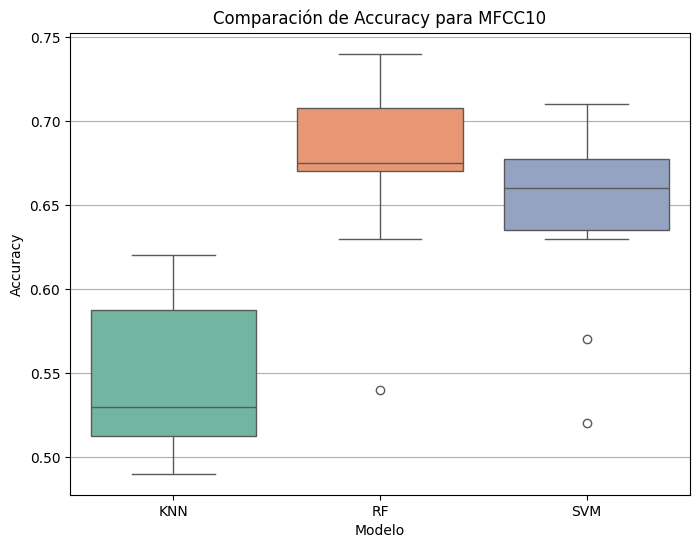

C:\Users\colbe\AppData\Local\Temp\ipykernel_11688\761744924.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Modelo', y='Accuracy', data=df[df['MFCC'] == mfcc], palette='Set2')


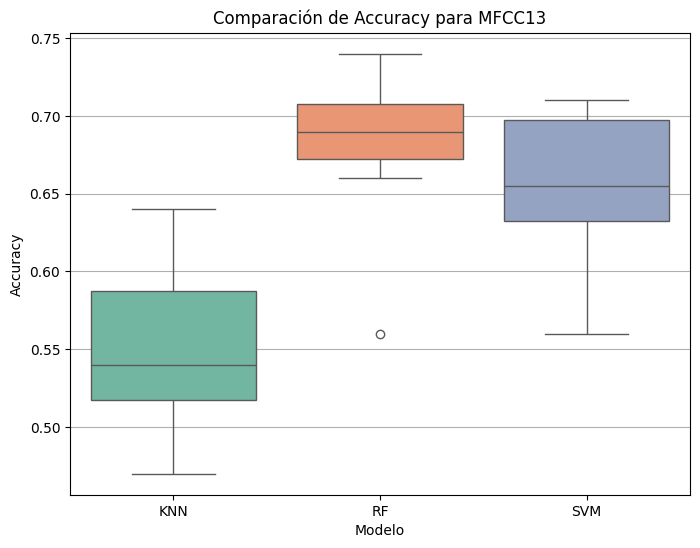

C:\Users\colbe\AppData\Local\Temp\ipykernel_11688\761744924.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Modelo', y='Accuracy', data=df[df['MFCC'] == mfcc], palette='Set2')


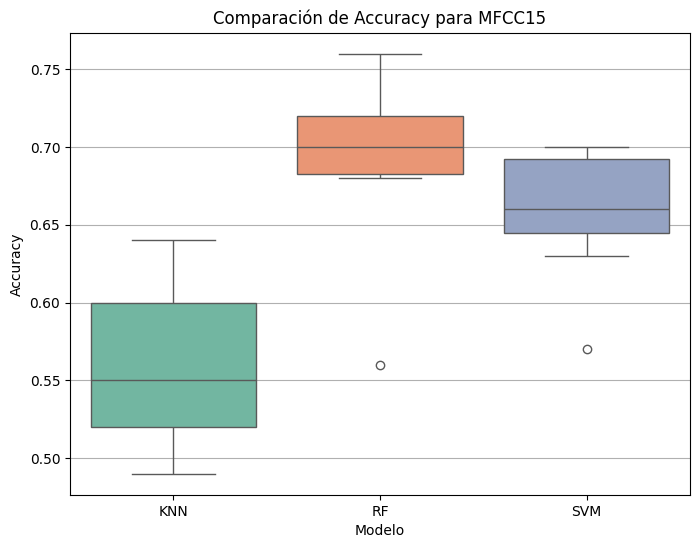

C:\Users\colbe\AppData\Local\Temp\ipykernel_11688\761744924.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Modelo', y='Accuracy', data=df[df['MFCC'] == mfcc], palette='Set2')


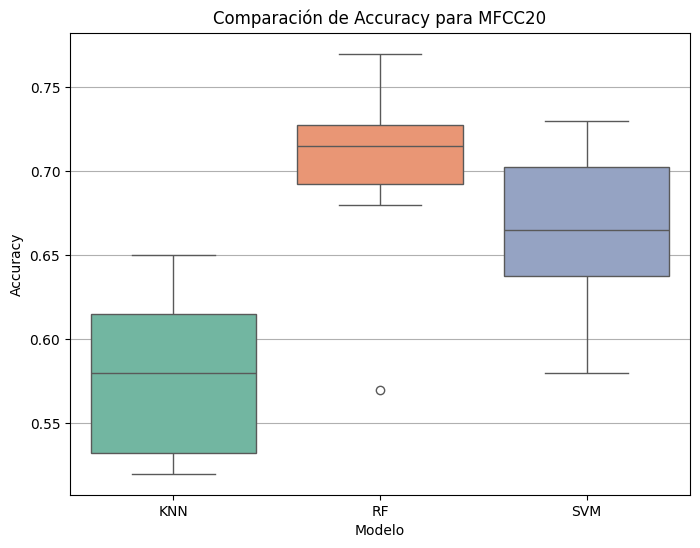

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Paso 1: Organizar tus datos en un DataFrame

# Crear una lista con los nombres de los folds
folds = ['FOLD1', 'FOLD2', 'FOLD3', 'FOLD4', 'FOLD5', 'FOLD6', 'FOLD7', 'FOLD8', 'FOLD9', 'FOLD10']

# Datos de exactitud para cada modelo y configuración de MFCC
data = {
    'FOLD': folds * 12,  # 10 folds para cada combinación de modelo y MFCC (10 folds x 12 combinaciones)
    'MFCC': ['MFCC10'] * 30 + ['MFCC13'] * 30 + ['MFCC15'] * 30 + ['MFCC20'] * 30,
    'Modelo': (['KNN'] * 10 + ['RF'] * 10 + ['SVM'] * 10) * 4,
    'Accuracy': [
        # MFCC10 - KNN
        0.51, 0.53, 0.49, 0.58, 0.62, 0.52, 0.50, 0.53, 0.62, 0.59,
        # MFCC10 - RF
        0.67, 0.63, 0.54, 0.72, 0.71, 0.67, 0.68, 0.67, 0.70, 0.74,
        # MFCC10 - SVM
        0.66, 0.57, 0.52, 0.69, 0.66, 0.63, 0.71, 0.68, 0.67, 0.65,
        # MFCC13 - KNN
        0.51, 0.54, 0.47, 0.59, 0.64, 0.54, 0.51, 0.54, 0.64, 0.58,
        # MFCC13 - RF
        0.68, 0.66, 0.56, 0.70, 0.71, 0.69, 0.69, 0.67, 0.71, 0.74,
        # MFCC13 - SVM
        0.64, 0.62, 0.56, 0.63, 0.66, 0.66, 0.71, 0.71, 0.71, 0.65,
        # MFCC15 - KNN
        0.51, 0.55, 0.49, 0.60, 0.64, 0.55, 0.52, 0.52, 0.64, 0.60,
        # MFCC15 - RF
        0.69, 0.68, 0.56, 0.72, 0.74, 0.68, 0.69, 0.72, 0.71, 0.76,
        # MFCC15 - SVM
        0.66, 0.63, 0.57, 0.66, 0.66, 0.67, 0.70, 0.70, 0.70, 0.64,
        # MFCC20 - KNN
        0.53, 0.57, 0.52, 0.62, 0.65, 0.59, 0.54, 0.53, 0.65, 0.60,
        # MFCC20 - RF
        0.71, 0.72, 0.57, 0.70, 0.76, 0.69, 0.68, 0.73, 0.72, 0.77,
        # MFCC20 - SVM
        0.63, 0.63, 0.58, 0.67, 0.71, 0.68, 0.71, 0.66, 0.73, 0.66
    ]
}

# Crear el DataFrame
df = pd.DataFrame(data)

# Ajustar la columna 'Modelo' para que se repita correctamente
models = ['KNN'] * 10 + ['RF'] * 10 + ['SVM'] * 10
df['Modelo'] = models * 4  # Multiplicar por 4 porque hay 4 configuraciones de MFCC

# Paso 2: Crear un DataFrame separado para cada MFCC y generar los boxplots

mfcc_list = ['MFCC10', 'MFCC13', 'MFCC15', 'MFCC20']

for mfcc in mfcc_list:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='Modelo', y='Accuracy', data=df[df['MFCC'] == mfcc], palette='Set2')
    plt.title(f'Comparación de Accuracy para {mfcc}')
    plt.ylabel('Accuracy')
    plt.xlabel('Modelo')
    plt.grid(axis='y')
    plt.show()


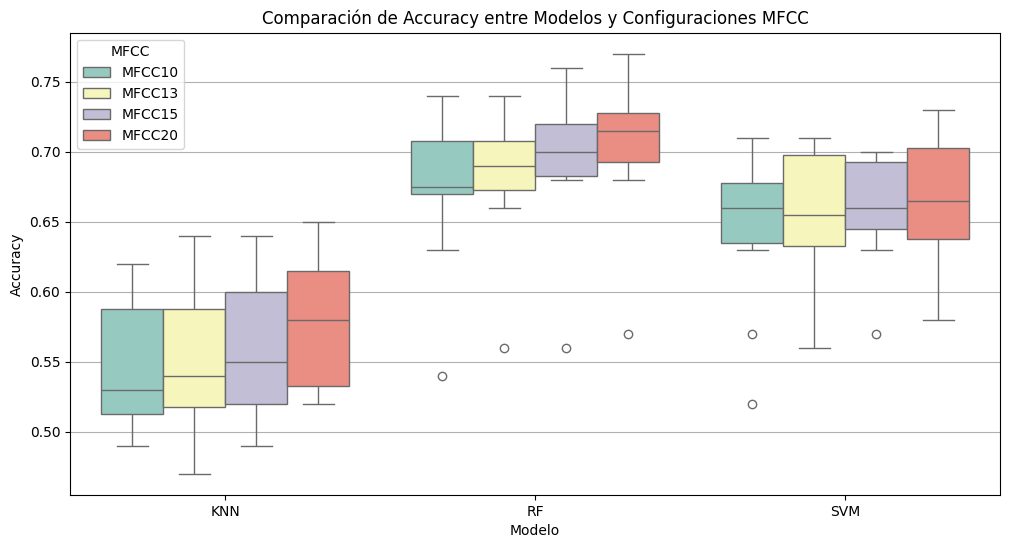

In [4]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Modelo', y='Accuracy', hue='MFCC', data=df, palette='Set3')
plt.title('Comparación de Accuracy entre Modelos y Configuraciones MFCC')
plt.ylabel('Accuracy')
plt.xlabel('Modelo')
plt.legend(title='MFCC')
plt.grid(axis='y')
plt.show()


In [33]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from scipy.stats import expon, reciprocal, randint, uniform
import numpy as np
print(uniform(0.1, 1000))